# GAN

- Generator, descriminator
- We freeze these two main parts one at the time. 
- Generator input is noise, sampled from latent space
- Latent space is like the opposite of features transfomration/embedding



In [4]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [5]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean = (0.5,), std = (0.5,))
    ])

In [6]:
train_dataset = torchvision.datasets.MNIST(
    root = '.',
    train = True,
    transform=transform,
    download= True
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████| 9912422/9912422 [00:01<00:00, 5303974.91it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████| 28881/28881 [00:00<00:00, 269461.69it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████| 1648877/1648877 [00:00<00:00, 1872257.66it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████| 4542/4542 [00:00<00:00, 20309732.16it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [7]:
len(train_dataset)

60000

In [8]:
batch_size = 128
data_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

In [9]:
D = nn.Sequential(
    nn.Linear(784, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1),
)

In [10]:
latent_dim = 100
G = nn.Sequential(
    nn.Linear(latent_dim, 256),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(256, momentum=0.7),
    nn.Linear(256, 512),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(512, momentum=0.7),
    nn.Linear(512, 1024),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(1024, momentum=0.7),
    nn.Linear(1024, 784),
    nn.Tanh()
)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
D = D.to(device)
G = G.to(device)

In [12]:
criterion = nn.BCEWithLogitsLoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [13]:
def scale_image(img):
  out = (img + 1) / 2
  return out

In [14]:
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [15]:
ones_ = torch.ones(batch_size, 1).to(device)
zeros_ = torch.zeros(batch_size, 1).to(device)

d_losses = []
g_losses = []

for epoch in range(200):
  for inputs, _ in data_loader:
    n = inputs.size(0)
    inputs = inputs.reshape(n, 784).to(device)
    ones = ones_[:n]
    zeros = zeros_[:n]
    # real iomages
    real_outputs = D(inputs)
    d_loss_real = criterion(real_outputs, ones)

    # fake images
    noise = torch.randn(n, latent_dim).to(device)
    fake_images = G(noise)
    fake_outputs = D(fake_images)
    d_loss_fake = criterion(fake_outputs, zeros)

    # gradient descent step
    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()
    # train generator
    for _ in range(2):
      # fake images
      noise = torch.randn(n, latent_dim).to(device)
      fake_images = G(noise)
      fake_outputs = D(fake_images)
      g_loss = criterion(fake_outputs, ones)
      d_optimizer.zero_grad()
      g_optimizer.zero_grad()
      g_loss.backward()
      g_optimizer.step()

    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())

  print(f"Epoch: {epoch}, d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")

  fake_images = fake_images.reshape(-1, 1, 28, 28)
  save_image(scale_image(fake_images), f"gan_images/{epoch+1}.png")

Epoch: 0, d_loss: 0.6825740337371826, g_loss: 0.7124381065368652
Epoch: 1, d_loss: 0.6809436678886414, g_loss: 0.7637215852737427
Epoch: 2, d_loss: 0.656737208366394, g_loss: 0.8562765121459961
Epoch: 3, d_loss: 0.7019298076629639, g_loss: 0.6888418197631836
Epoch: 4, d_loss: 0.7017276287078857, g_loss: 0.6775803565979004
Epoch: 5, d_loss: 0.7014298439025879, g_loss: 0.6568302512168884
Epoch: 6, d_loss: 0.6876984238624573, g_loss: 0.7033311724662781
Epoch: 7, d_loss: 0.6835051774978638, g_loss: 0.753077507019043
Epoch: 8, d_loss: 0.6959874033927917, g_loss: 0.7638784646987915
Epoch: 9, d_loss: 0.6929508447647095, g_loss: 0.686477541923523
Epoch: 10, d_loss: 0.6815299391746521, g_loss: 0.7458974719047546
Epoch: 11, d_loss: 0.6868116855621338, g_loss: 0.7372807860374451
Epoch: 12, d_loss: 0.6802108287811279, g_loss: 0.7157859206199646
Epoch: 13, d_loss: 0.7039209604263306, g_loss: 0.7059633135795593
Epoch: 14, d_loss: 0.684628963470459, g_loss: 0.6808648109436035
Epoch: 15, d_loss: 0.707

Epoch: 125, d_loss: 0.5885292291641235, g_loss: 0.8474072813987732
Epoch: 126, d_loss: 0.6077467203140259, g_loss: 1.1380213499069214
Epoch: 127, d_loss: 0.6381979584693909, g_loss: 0.9814642667770386
Epoch: 128, d_loss: 0.617397665977478, g_loss: 0.7412333488464355
Epoch: 129, d_loss: 0.6109180450439453, g_loss: 1.1220719814300537
Epoch: 130, d_loss: 0.6180534362792969, g_loss: 1.1092376708984375
Epoch: 131, d_loss: 0.6317788362503052, g_loss: 1.1016789674758911
Epoch: 132, d_loss: 0.6082296371459961, g_loss: 1.1482552289962769
Epoch: 133, d_loss: 0.6283808946609497, g_loss: 0.7577570676803589
Epoch: 134, d_loss: 0.6445176601409912, g_loss: 1.371634840965271
Epoch: 135, d_loss: 0.6127724647521973, g_loss: 0.7655403017997742
Epoch: 136, d_loss: 0.6105997562408447, g_loss: 0.880027711391449
Epoch: 137, d_loss: 0.6196219325065613, g_loss: 0.9287558794021606
Epoch: 138, d_loss: 0.6205891370773315, g_loss: 1.1127275228500366
Epoch: 139, d_loss: 0.6004757881164551, g_loss: 0.884938716888427

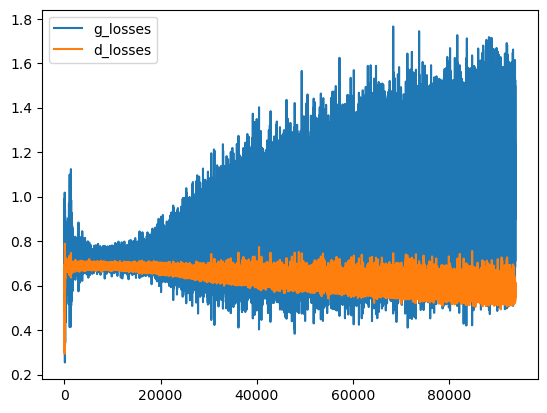

In [16]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

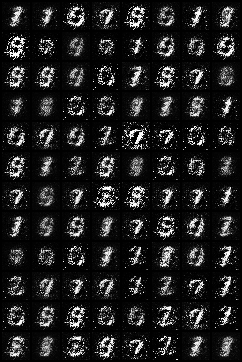

In [21]:
from IPython.display import Image
Image(filename='gan_images/1.png') 

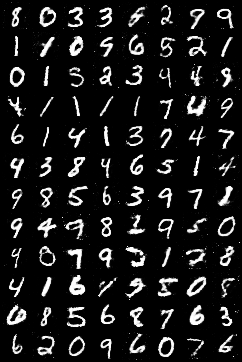

In [22]:
from IPython.display import Image
Image(filename='gan_images/200.png') 